In [ ]:
# Install the ArcGIS API for Python 

# Read the API Docs => https://developers.arcgis.com/python/ 

!pip install arcgis

In [4]:
# Import neccessary libraries 
import requests
import pandas as pd

from IPython.display import display
from arcgis.gis import GIS
import os
gis = GIS('https://arcgis.com/', '<your-username>', '<your-password>')

In [ ]:
#=> You might want to install this for the first time. Comment out the code after running the script for the first time

!pip install openpyxl

Where to find the `kobo_asset_url`? Follow this docs for using [synchronous exports](https://support.kobotoolbox.org/synchronous_exports.html)

Try to get the *excel file* in this case for this example. 

Where to find the `access token`? Check out the [official API docs here](https://support.kobotoolbox.org/api.html)

In [ ]:
#=> You might want to check to see if you can access your data first before running the script
 
import pandas as pd 
kobo_data = pd.read_excel(kobo_asset_url)
kobo_data.head()

In [8]:
# Asset ID 
kobo_asset_url = # Fill in here

# Authentication credentials
username = "<your-username>"
password = "<your-password>"


# API endpoint and export token
kobo_api_url = f"{kobo_asset_url}"
export_token = "<your-token-here>"

# Create a session with authentication
session = requests.Session()
session.auth = (username, password)

# Construct the export URL
kobo_export_url = f"{kobo_api_url}/data.xlsx?format=xlsx&token={export_token}"

# Fetch data using the authenticated session
response = session.get(kobo_export_url)

# Check if the request was successful
if response.status_code == 200:
    # Load data into a pandas DataFrame
    kobo_data = pd.read_excel(response.content)
    kobo_data.head()
else:
    print("Error:", response.status_code)


In [9]:
# What are the column names created by Kobo? 
# Get the column names
kobo_column_names = kobo_data.columns.tolist()

# Display the column names
print(kobo_column_names)

#=> This helps incase we might need to change some naming 

['Country', 'Admin Level 1', 'Admin Level 2', 'Admin Level 3', 'Admin Level 4', 'Village/Place Name', 'Location (Coordinates)', '_Location (Coordinates)_latitude', '_Location (Coordinates)_longitude', '_Location (Coordinates)_altitude', '_Location (Coordinates)_precision', 'In Which Pillar?', 'Project(s)', 'Type of Participant', 'Participant ID:', 'Full name', 'Gender', 'Date of Birth', 'Age', 'Age: ${Age}', 'Position', 'Organisation', 'National ID Number', 'Mobile Phone Number', '_uuid', '_status']


In [16]:
import geopandas as gpd
import zipfile

# => Refer to this section if you have any date field. Replace with your field names

# Convert datetime columns to string format
# kobo_data['today'] = kobo_data['today'].astype(str)
# kobo_data['Date'] = kobo_data['Date'].astype(str)
kobo_data['Date of Birth'] = kobo_data['Date of Birth'].astype(str)

# Convert the DataFrame to a GeoDataFrame
geometry = gpd.points_from_xy(kobo_data['_Location (Coordinates)_longitude'], kobo_data['_Location (Coordinates)_latitude'])
gdf = gpd.GeoDataFrame(kobo_data, geometry=geometry)

# Set the CRS (Coordinate Reference System) for the GeoDataFrame
crs = '+proj=longlat +datum=WGS84 +no_defs'
gdf.crs = crs

# Path to save the shapefile
shapefile_path = 'geo_data/cms_registrations.shp'

# Save the GeoDataFrame as a shapefile
gdf.to_file(shapefile_path, driver='ESRI Shapefile')

# Create a zip file
zip_file = 'zipped_data/cms_registrations.zip'
with zipfile.ZipFile(zip_file, 'w') as zf:
    # Add shapefile files to the zip
    for extension in ['.shp', '.shx', '.dbf', '.prj']:
        file_path = shapefile_path.replace('.shp', extension)
        zf.write(file_path, arcname=file_path.split('/')[-1])

print('Shapefile zipped successfully.')


C:\Users\Kumbirai.Matingo\AppData\Local\Temp\ipykernel_21100\3960691370.py:21: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(shapefile_path, driver='ESRI Shapefile')


Shapefile zipped successfully.


## Publishing Shapefile 

_comment out this section when overwriting existing layer_

In [17]:
# Publish the Shapefile 
zipped_shp = gis.content.add({}, zip_file)
# Display the Published SHP 
zipped_shp

<Item title:"cms_registrations" type:Shapefile owner:kumbirai.matingo>

In [21]:
# Publish as Feature Service
published_shp = zipped_shp.publish()
# Display the Published Feature Service 
display(published_shp)

<Item title:"cms_registrations" type:Feature Layer Collection owner:kumbirai.matingo>

<Item title:"CMS - Registrations" type:Feature Layer Collection owner:kumbirai.matingo>
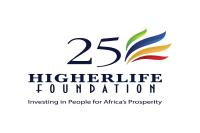

In [22]:
# Update the property information of the feature layer 
thumbnail_path = "https://yt3.googleusercontent.com/l_P5gHisFM-cYA0qGXcQZZPFs0pEhbSrx5NLxgaEvfmbnZj46TKFEcgyz--ytrwjcvM13eOua9Y=s900-c-k-c0x00ffffff-no-rj"
item_properties = {"snippet":"""Feature layer containing Case-Management-System registration data from the kobotoolbox""",
                   "title":"CMS - Registrations",
                   "tags":"Higherlife Foundation, KobotoolBox, CaseManagementSystem, Registration"}

published_shp.update(item_properties, thumbnail=thumbnail_path)
display(published_shp)

**commenting of code ends here when updating/overwriting**

## Updating the Feature Layer with new Data from Kobo 

This section manages the update of information and contents of the Kobo forms to AGOL for automatic mapping and integration into spatial dashboards. 

In [ ]:
from arcgis.features import FeatureLayerCollection
kobo_FL = FeatureLayerCollection.fromitem(published_shp) # try: zipped_shp instead 

# Overwrite the FL 
kobo_FL.manager.overwrite(zip_file)

To look into this resource which could be helpful for updating the data - https://community.kobotoolbox.org/t/kobo-form-to-arcgis-online-feature-service/11716/8